# Reinforcement learning project

In [1]:
import copy
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from Chess_env import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from degree_freedom_queen import *
from generate_game import *
from neural_network import *
from utils import *

### Set Seed

In [2]:
np.random.seed(42)

### Set Hyperparameters

In [3]:
N_episodes = 50000    # number of episodes
epsilon_0 = 0.20      # starting value for epsilon greedy
beta = 0.00005        # epsilon decay rate
gamma = 0.85          # discount factor
eta = 0.0001          # learning rate for neural netowork
n_target_updates = 10 # freuqency of update for target network

# beta = 0.005         # epsilon decay rate
# gamma = 0.50         # discount factor


### Define environment

In [4]:
size_board = 4

env = Chess_Env(size_board)
S, X, allowed_a = env.Initialise_game()

### Define neural network

In [5]:
N_a = np.shape(allowed_a)[0]   # total number of possible actions
N_in = np.shape(X)[0]          # input size to network
N_h = 256                      # number of hidden neurons

model_nn = NeuralNetwork(input_size=N_in, output_size=N_a, hidden_size=N_h ,learning_rate = eta)  # main network
target_nn = copy.deepcopy(model_nn)                                                               # target network

### Saving variables

In [6]:
# SAVING VARIABLES
r_save = []       # save total rewards per episode
n_moves_save = [] # save number of moves per episode
win_draw = []     # save whether agent won or draw

# SARSA

In [7]:
for n in tqdm(range(N_episodes)):
  epsilon_f = epsilon_0 / (1 + beta * n)   # decay epsilon
  done = 0                                 # not done
  i = 1                                    # number of moves
  
  S, X, allowed_a = env.Initialise_game()      # reset environment

  X = np.concatenate([np.array(X), np.array([1])]).reshape(-1,1) # pad with one for bias

  tot_r = 0


  while done == 0:                           # start episode
    q_vals, h = model_nn.forward(X)          # get q values from network and preactivations

    action = choose_action(q_vals, allowed_a, epsilon_f) # choose action using epsilon greedy

    S_next, X_next, allowed_a_next, R, done = env.OneStep(action)  # take step
    X_next = np.concatenate([np.array(X_next), np.array([1])]).reshape(-1,1) 

    
    if done==1:  # episode is done
      target = R  # target reward
      if(R==10): # if won
        win_draw.append(1)
      else:      # if draw
        win_draw.append(0)

      target_vector = np.copy(q_vals)    
      target_vector[action] = target    # get target q value

    else:
      q_vals_next, _ = target_nn.forward(X_next)    # use target net to get future q value
      action_next = choose_action(q_vals_next, allowed_a_next, epsilon_f)  # choose next action according to epsilon greedy

      target = R + gamma * q_vals_next[action_next]  # set target
      target_vector = np.copy(q_vals)
      target_vector[action] = target


    model_nn.fit(target_vector, q_vals, h, X)   # fit the model
   
    tot_r += R  # add total reward

    # NEXT STATE AND CO. BECOME ACTUAL STATE...     
    S = np.copy(S_next)
    X = np.copy(X_next)
    allowed_a = np.copy(allowed_a_next)
    
    i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


  r_save.append(tot_r)
  n_moves_save.append(i)
    
  if(n%n_target_updates==0):
      target_nn = copy.deepcopy(model_nn)   # update the target network
  

100%|██████████| 50000/50000 [03:14<00:00, 257.58it/s]


## Plot graphs


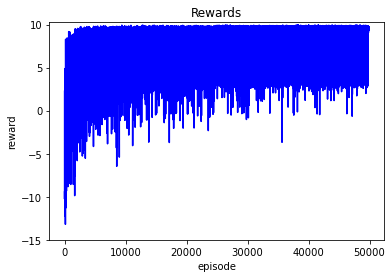

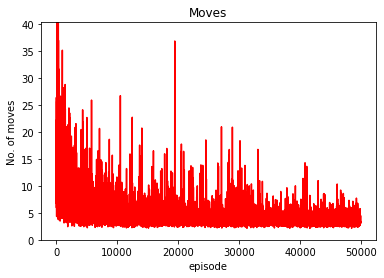

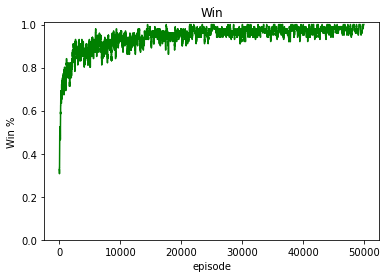

In [8]:
plot(r_save, 'Rewards', 'episode', 'reward', c = 'b', exp=True, ylim=(-15,10.25))
plot(n_moves_save, 'Moves', 'episode', 'No. of moves', c = 'r', exp=True, ylim=(0, 40.25))
plot(win_draw, 'Win', 'episode', 'Win %', c = 'g', exp=False, ylim = (0,1.01))

## Reset network and variables

In [9]:
# neural network
model_nn = NeuralNetwork(input_size=N_in, output_size=N_a, hidden_size=N_h ,learning_rate = eta)
target_nn = copy.deepcopy(model_nn)

In [10]:
r_save = []
n_moves_save = []
win_draw = []

# Q Learning

In [11]:
for n in tqdm(range(N_episodes)):
  epsilon_f = epsilon_0 / (1 + beta * n)   # decay epsilon
  done = 0                                 # not done
  i = 1                                    # number of moves
  
  S, X, allowed_a = env.Initialise_game()      # reset environment

  X = np.concatenate([np.array(X), np.array([1])]).reshape(-1,1) # pad with one for bias

  tot_r = 0


  while done == 0:                           # start episode
    q_vals, h = model_nn.forward(X)          # get q values from network and preactivations

    action = choose_action(q_vals, allowed_a, epsilon_f) # choose action using epsilon greedy

    S_next, X_next, allowed_a_next, R, done = env.OneStep(action)  # take step
    X_next = np.concatenate([np.array(X_next), np.array([1])]).reshape(-1,1) 

    
    if done==1:  # episode is done
      target = R  # target reward
      if(R==10): # if won
        win_draw.append(1)
      else:      # if draw
        win_draw.append(0)

      target_vector = np.copy(q_vals)    
      target_vector[action] = target    # get target q value

    else:
      q_vals_next, _ = target_nn.forward(X_next)    # use target net to get future q value
      q_valid_next = q_vals_next * allowed_a_next
      q_valid_next[allowed_a_next==0] = -np.inf

      target = R + gamma * max(np.max(q_valid_next), 0) 
      target_vector = np.copy(q_vals)
      target_vector[action] = target


    model_nn.fit(target_vector, q_vals, h, X)   # fit the model
   
    tot_r += R  # add total reward

    # NEXT STATE AND CO. BECOME ACTUAL STATE...     
    S = np.copy(S_next)
    X = np.copy(X_next)
    allowed_a = np.copy(allowed_a_next)
    
    i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


  r_save.append(tot_r)
  n_moves_save.append(i)
  
  if(n%n_target_updates==0):
      target_nn = copy.deepcopy(model_nn)   # update the target network

100%|██████████| 50000/50000 [04:28<00:00, 186.34it/s]


### Plot graphs

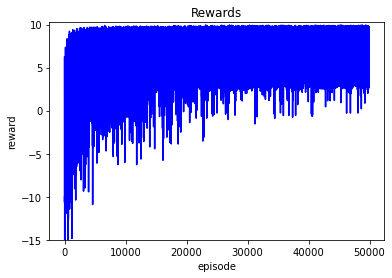

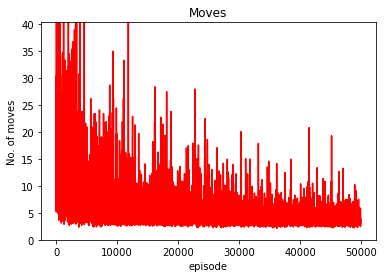

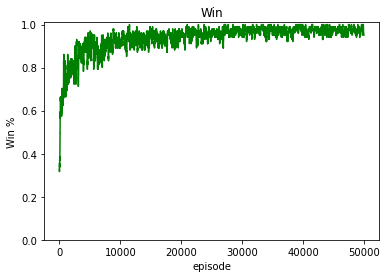

In [12]:
plot(r_save, 'Rewards', 'episode', 'reward', c = 'b', exp=True, ylim=(-15,10.25))
plot(n_moves_save, 'Moves', 'episode', 'No. of moves', c = 'r', exp=True, ylim=(0, 40.25))
plot(win_draw, 'Win', 'episode', 'Win %', c = 'g', exp=False, ylim = (0,1.01))